In [20]:
import os
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from keras.utils import to_categorical


from sklearn.utils.class_weight import compute_class_weight

In [21]:
def load_dataset(image_dir, label):
    file_names = os.listdir(image_dir)

    images = []
    for file_name in file_names:
        file_path = os.path.join(image_dir, file_name)

        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            images.append(image)


    rows = 1
    cols = 5
    c = 1
    for i in range (0,5):
        plt.subplot(rows, cols, c)
        c+=1
        plt.imshow(images[i], plt.get_cmap('gray'))

    plt.show()

    images = np.array(images)
    images = images/255

    images = images.reshape(images.shape[0], -1)

    y_train = ( images.shape[0])*[ label ]
    y_train = np.array(y_train)

    return [images, y_train]




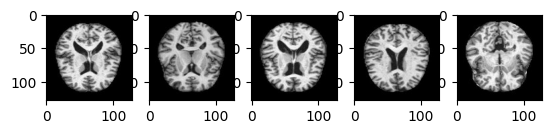

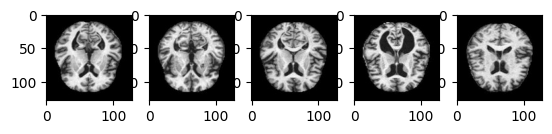

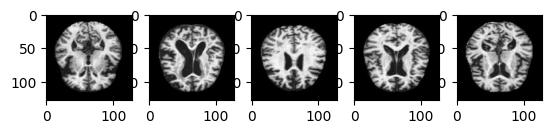

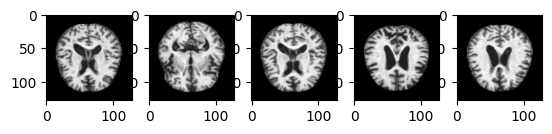

x train: (3128, 16384)
x validation: (391, 16384)
x test: (391, 16384)


In [22]:
# loading dataset 1
[x_train_0, y_train_0] = load_dataset("./Dataset1/Non_Demented", 0 )
[x_train_1, y_train_1] = load_dataset("./Dataset1/Very_Mild_Demented", 1)
[x_train_2, y_train_2] = load_dataset("./Dataset1/Mild_Demented", 2)
[x_train_3, y_train_3] = load_dataset("./Dataset1/Moderate_Demented", 3)

# print(X_train_1_1_1_0.shape, x_train_1.shape, x_train_2.shape, x_train_3.shape )



class_dict_1 = {"Non_Demented": y_train_0.shape[0], "Very_Mild_Demented": y_train_1.shape[0], "Mild_Demented": y_train_2.shape[0], "Moderate_Demented": y_train_3.shape[0]}


X = np.concatenate((x_train_0, x_train_1, x_train_2, x_train_3 ))
Y = np.concatenate((y_train_0, y_train_1, y_train_2, y_train_3 ))


indices = np.random.choice(X.shape[0], size = X.shape[0], replace = False)
X = X[indices]
Y = Y[indices]


# print(X.shape, Y.shape)

X_train_1 = X[: int(X.shape[0] * 0.80)]
Y_train_1 = Y[: int(X.shape[0] * 0.80)]

X_val_1 = X[int(X.shape[0] * 0.80) : int(X.shape[0] * 0.90)]
Y_val_1 = Y[int(Y.shape[0] * 0.80) : int(Y.shape[0] * 0.90)]

X_test_1 = X[int(X.shape[0] * 0.90) : ]
Y_test_1 = Y[int(X.shape[0] * 0.90) : ]

print(f"x train: {X_train_1.shape}")
print(f"x validation: {X_val_1.shape}")
print(f"x test: {X_test_1.shape}")



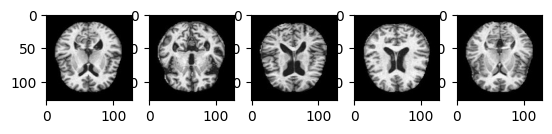

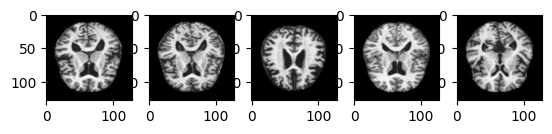

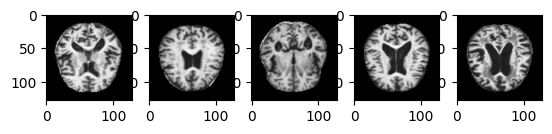

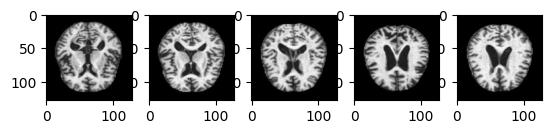

x train: (1992, 16384)
x validation: (249, 16384)
x test: (249, 16384)


In [23]:
# loading dataset 2

[x_train_0, y_train_0] = load_dataset("./Dataset2/Non_Demented", 0 )
[x_train_1, y_train_1] = load_dataset("./Dataset2/Very_Mild_Demented", 1)
[x_train_2, y_train_2] = load_dataset("./Dataset2/Mild_Demented", 2)
[x_train_3, y_train_3] = load_dataset("./Dataset2/Moderate_Demented", 3)

# print(x_train_0.shape, x_train_1.shape, x_train_2.shape, x_train_3.shape )


class_dict_2 = {"Non_Demented": y_train_0.shape[0], "Very_Mild_Demented": y_train_1.shape[0], "Mild_Demented": y_train_2.shape[0], "Moderate_Demented": y_train_3.shape[0]}


X = np.concatenate((x_train_0, x_train_1, x_train_2, x_train_3 ))
Y = np.concatenate((y_train_0, y_train_1, y_train_2, y_train_3 ))


indices = np.random.choice(X.shape[0], size = X.shape[0], replace = False)
X = X[indices]
Y = Y[indices]


# print(X.shape, Y.shape)

X_train_2 = X[: int(X.shape[0] * 0.80)]
Y_train_2 = Y[: int(X.shape[0] * 0.80)]

X_val_2 = X[int(X.shape[0] * 0.80) : int(X.shape[0] * 0.90)]
Y_val_2 = Y[int(Y.shape[0] * 0.80) : int(Y.shape[0] * 0.90)]

X_test_2 = X[int(X.shape[0] * 0.90) : ]
Y_test_2 = Y[int(X.shape[0] * 0.90) : ]

print(f"x train: {X_train_2.shape}")
print(f"x validation: {X_val_2.shape}")
print(f"x test: {X_test_2.shape}")



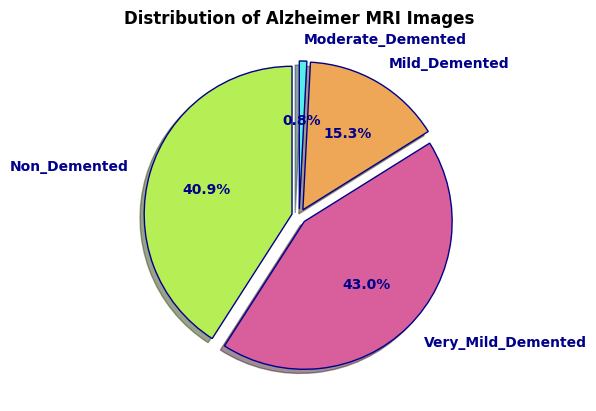

In [24]:
# pie chart for classes
def pie_chart(class_dict):

        colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]
        keys = list(class_dict.keys())
        values = list(class_dict.values())
        explode = (0.05,)*len(keys)

        labels = [f'{key}' for key in keys]

        plt.pie(values, explode=explode,labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90, colors=colors, textprops={'fontsize': 10, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
                {'edgecolor':'darkblue'} , labeldistance=1.15)
        plt.title("Distribution of Alzheimer MRI Images", size=12, fontweight="bold")
pie_chart(class_dict_1)


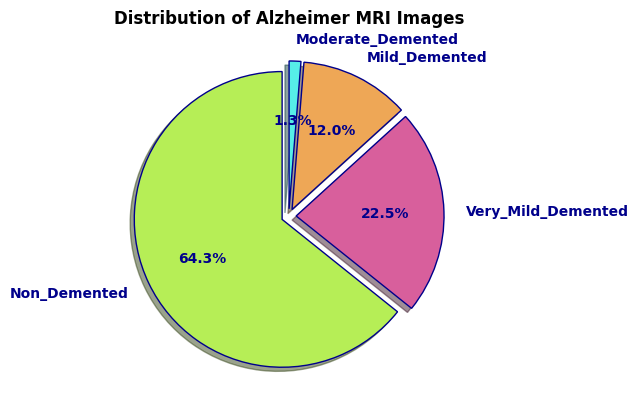

In [25]:
pie_chart(class_dict_2)

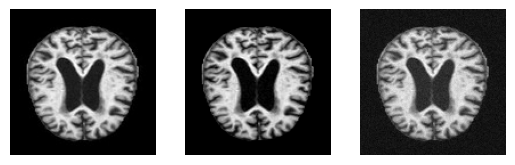

(9128, 16384)


In [26]:

# Applying Data augumentation on the train set

def apply_brightness(image, max_delta=50):
    delta = np.random.randint(-max_delta, max_delta)
    bright_image = np.clip(image.astype(np.int16) + delta, 0, 255).astype(np.uint8)
    return bright_image

def add_gaussian_noise(image, mean=0, stddev=5):
    noise = np.random.normal(mean, stddev, image.shape).astype(np.float64)
    noisy_image = cv2.add(image, noise)
    return noisy_image

X_train_augmented = []
Y_train_augmented = []


for i in range(3000):
    image = X_train_1[i]
    y_image = Y_train_1[i]
    image= image.reshape((128, 128))
    image = image * 255


    X_train_augmented.append(image)
    Y_train_augmented.append(y_image)

    brightened_image = apply_brightness(image)
    X_train_augmented.append(brightened_image)
    Y_train_augmented.append(y_image)

    noisy_image = add_gaussian_noise(image)
    X_train_augmented.append(noisy_image)
    Y_train_augmented.append(y_image)

X_train_augmented = np.array(X_train_augmented)
Y_train_augmented = np.array(Y_train_augmented)


# printing the original image , brightened, image with added noise
rows = 1
cols = 3
for i in range(3):
    plt.subplot(rows, cols, i+1)
    plt.imshow(X_train_augmented[i], cmap='gray')
    plt.axis('off')
plt.show()

X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], -1)
X_train_augmented = X_train_augmented/255


X_train_1 = np.concatenate([X_train_augmented , X_train_1[3000:]])
Y_train_1 = np.concatenate([Y_train_augmented , Y_train_1[3000:]])



indices = np.random.choice(X_train_1.shape[0], size = X_train_1.shape[0], replace = False)
X_train_1 = X_train_1[indices]
Y_train_1 = Y_train_1[indices]
# print(X_train_1.shape)
# X_train_1 = X_train_1.reshape(X_train_1.shape[0], -1)
# X_train_1 = X_train_1 / 255

print(X_train_1.shape)




In [27]:
# graph of cummulative explained variance VS no of dimensions to be taken for PCA

# pca = PCA(n_components=6000)
# pca.fit(X_train_1)

# # Get explained variance ratio
# explained_variance_ratio = pca.explained_variance_ratio_

# # Calculate cumulative explained variance
# cumulative_variance = np.cumsum(explained_variance_ratio)

# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(cumulative_variance, marker='o', linestyle='-')
# plt.title('Cumulative Summation of Explained Variance')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.grid(True)
# plt.show()

In [28]:

def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # 4 classes
    return model


In [29]:
# CNN model on 1st dataset
model1 = cnn_model()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(X_train_1.shape)
num_classes = 4

Y_train_one_hot = to_categorical(Y_train_1, num_classes)
Y_val_one_hot = to_categorical(Y_val_1, num_classes)
Y_test_one_hot = to_categorical(Y_test_1, num_classes)

X_train_1 = X_train_1.reshape(-1, 128, 128, 1)
X_val_1 = X_val_1.reshape(-1, 128, 128, 1)
X_test_1 = X_test_1.reshape(-1, 128, 128, 1)

# 4. Train Model
history1 = model1.fit(X_train_1, Y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_val_1, Y_val_one_hot))

# 5. Evaluate Model
test_loss_1, test_acc_1 = model1.evaluate(X_test_1, Y_test_one_hot)
print('Test accuracy:', test_acc_1)

# 6. Predictions
predictions_1 = model1.predict(X_test_1)

(9128, 16384)
Epoch 1/10
286/286 [==============================] - 71s 248ms/step - loss: 0.8992 - accuracy: 0.5638 - val_loss: 0.7391 - val_accuracy: 0.6777
Epoch 2/10
286/286 [==============================] - 78s 272ms/step - loss: 0.3698 - accuracy: 0.8497 - val_loss: 0.3436 - val_accuracy: 0.8619
Epoch 3/10
286/286 [==============================] - 63s 221ms/step - loss: 0.0894 - accuracy: 0.9680 - val_loss: 0.2184 - val_accuracy: 0.9412
Epoch 4/10
286/286 [==============================] - 81s 283ms/step - loss: 0.0170 - accuracy: 0.9951 - val_loss: 0.2115 - val_accuracy: 0.9514
Epoch 5/10
286/286 [==============================] - 78s 272ms/step - loss: 0.0179 - accuracy: 0.9952 - val_loss: 0.2837 - val_accuracy: 0.9079
Epoch 6/10
286/286 [==============================] - 62s 215ms/step - loss: 0.0145 - accuracy: 0.9957 - val_loss: 0.2334 - val_accuracy: 0.9616
Epoch 7/10
286/286 [==============================] - 63s 220ms/step - loss: 1.8975e-04 - accuracy: 1.0000 - val_los

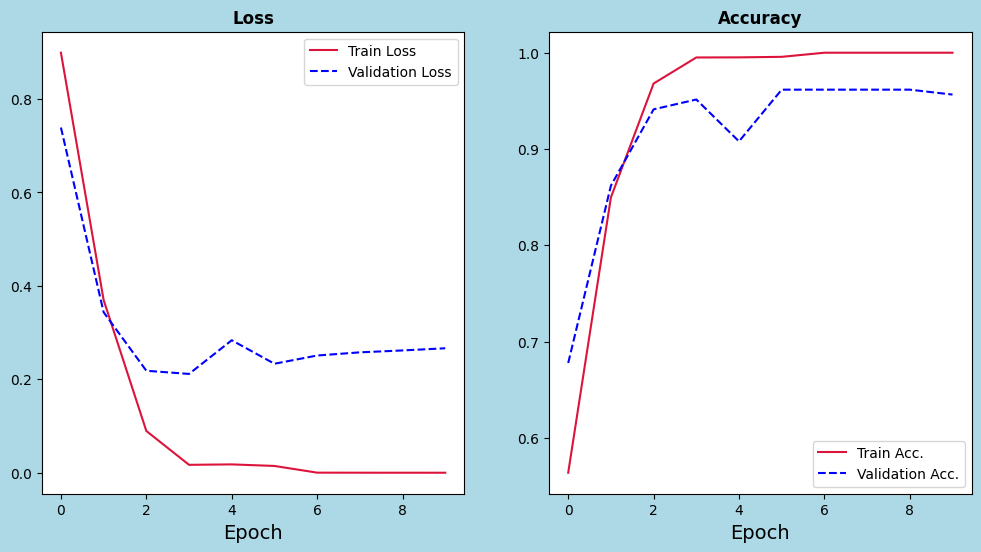

In [41]:
# evaluation metric for two datasets

fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="lightblue")
ax[0].set_facecolor('white')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history1.epoch, history1.history["loss"], label="Train Loss", color="crimson")
ax[0].plot(history1.epoch, history1.history["val_loss"], label="Validation Loss", color="blue", linestyle="--")
ax[0].legend()
ax[1].set_facecolor('white')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history1.epoch, history1.history["accuracy"], label="Train Acc.", color="crimson")
ax[1].plot(history1.epoch, history1.history["val_accuracy"], label="Validation Acc.", color="blue", linestyle="--")
ax[1].legend()
plt.show()



In [43]:

predicted_labels = np.argmax(predictions, axis=1)

# Print classification report
print(classification_report(Y_test, predicted_labels))

# applying cnn model on 2nd dataset for checking accuracy oveer genralised data.

X_test_2 = X_test_2.reshape(-1, 128, 128, 1)
test_loss_2, test_acc_2 = model1.evaluate(X_test_2, Y_test_one_hot)
print('Test accuracy:', test_acc_2)

# 6. Predictions
predictions_2 = model1.predict(X_test_2)

ValueError: Data cardinality is ambiguous:
  x sizes: 249
  y sizes: 391
Make sure all arrays contain the same number of samples.

In [74]:

#  PCA for the dataset
def calculate_pca(X_train, X_test, X_val, p):

    pca = PCA(n_components=p)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    X_val_pca = pca.transform(X_val)

    # applying QDA to find thhe accuracy corresponding to the dimensionality reduction

    # qda = QuadraticDiscriminantAnalysis()
    # qda.fit(X_train_pca, Y_train)

    # # Calculate the accuracy
    # accuracy = qda.score(X_test_pca, Y_test)
    # print("Accuracy after QDA on dimensionaly reduced dataset:", accuracy)
    return X_train_pca, X_test_pca, X_val_pca

#  taking PCA (p= 100), as it is the closest to the total accuracy without dimensional reduction


X_train_1 , X_test_1, X_val_1= calculate_pca(X_train_1, X_test_1, X_val_1, 500)
X_train_2 , X_test_2, X_val_2= calculate_pca(X_train_2, X_test_2, X_val_2, 500)
print(X_train_1.shape)
print(X_val_1.shape)
print(X_test_1.shape)

print(X_train_2.shape)
print(X_val_2.shape)
print(X_test_2.shape)


(3128, 500)
(391, 500)
(391, 500)
(1992, 500)
(249, 500)
(249, 500)


Validation Accuracy:  0.8056265984654731
Test accuracy:  0.7902813299232737
Accuracy of Non demented: 0.7278481012658228
Accuracy of Very Mild demented: 0.8444444444444444
Accuracy of Mild demented: 0.7884615384615384
Accuracy of Moderate demented: 1.0


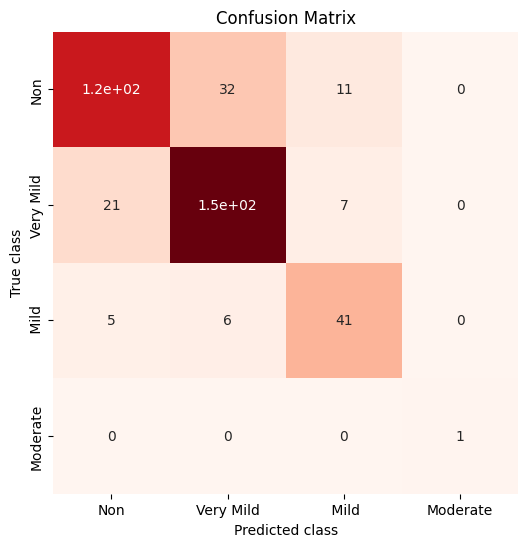

In [24]:
X_train = X_train_1
Y_train = Y_train_1

X_val = X_val_1
Y_val = Y_val_1

X_test = X_test_1
Y_test = Y_test_1
def find_class_accuracies(y_pred):
    classwise_correct_predicted_samples = [0] * 4
    classwise_total_samples = [0] * 4
    for i in range(Y_test.shape[0]):
        y = Y_test[i]
        classwise_total_samples[y]+=1
        if (y == y_pred[i]):
            classwise_correct_predicted_samples[y] +=1

    accuracies = [0] * 4
    for i in range(4):
        accuracies[i]= classwise_correct_predicted_samples[i] / classwise_total_samples[i]


    print(f"Accuracy of Non demented: {accuracies[0]}")
    print(f"Accuracy of Very Mild demented: {accuracies[1]}")
    print(f"Accuracy of Mild demented: {accuracies[2]}")
    print(f"Accuracy of Moderate demented: {accuracies[3]}")


# Model1: Multiclass Logistic Regression (Accuracy  = 67.3% )
log_reg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', max_iter=2000)
log_reg.fit(X_train, Y_train)

validation_accuracy = log_reg.score(X_val, Y_val)
print("Validation Accuracy: ", validation_accuracy)

test_accuracy = log_reg.score(X_test, Y_test)
print("Test accuracy: ", test_accuracy)
y_pred = log_reg.predict(X_test)
find_class_accuracies(y_pred)



# for the test set calculaitng the recall = no of true positives / total no of positives = no of true positives / no of true positives + no of false negatives

conf_matrix = confusion_matrix(Y_test, y_pred)

classes =['Non', 'Very Mild', ' Mild', 'Moderate' ]
plt.figure(figsize = (6,6), facecolor=(1,1,1,0))
sns.heatmap(conf_matrix, annot=True, cmap = 'Reds', cbar = False,xticklabels=classes , yticklabels=classes)

plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion Matrix")
plt.show()



In [27]:
# decision tree model - used cross validation to get the max depth to be choosen - (Accuracy = 73.125 %)

param_grid = {'max_depth': [25, 50 , 100]}
decision_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='accuracy')  # cross validation
grid_search.fit(X_train, Y_train)

best_depth = grid_search.best_params_['max_depth']
print(best_depth)

best_decision_tree = grid_search.best_estimator_

validation_accuracy = best_decision_tree.score(X_val, Y_val)
print("Validation Accuracy: ", validation_accuracy)

test_accuracy = best_decision_tree.score(X_test, Y_test)
print("Test accuracy: ", test_accuracy)
y_pred = best_decision_tree.predict(X_test)
find_class_accuracies(y_pred)



50
Validation Accuracy:  0.6675191815856778
Test accuracy:  0.6086956521739131
Accuracy of Non demented: 0.6139240506329114
Accuracy of Very Mild demented: 0.6611111111111111
Accuracy of Mild demented: 0.4230769230769231
Accuracy of Moderate demented: 0.0


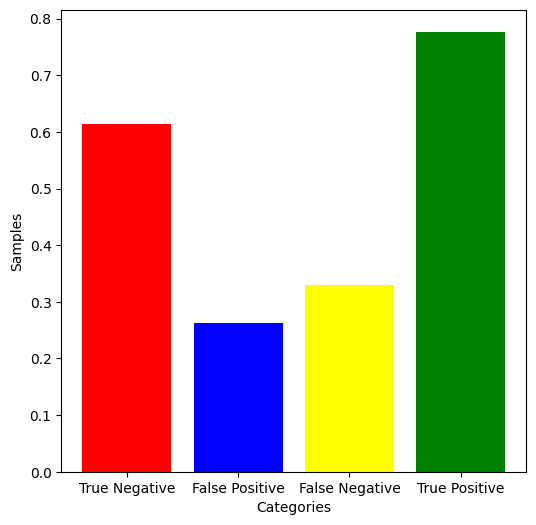

In [29]:
Y_pred = grid_search.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)

total_negative = np.sum(conf_matrix[0])
total_positive = Y_test.shape[0] - total_negative
tn = conf_matrix[0][0] / total_negative
fn = (conf_matrix[1][0] + conf_matrix[2][0] + conf_matrix[3][0]) / total_negative
fp = (conf_matrix[0][1] + conf_matrix[0][2] + conf_matrix[0][3]) / total_positive
tp = 0

for i in range(1,4):
    for j in range(1,4):
        tp += conf_matrix[i][j]
tp = tp / total_positive

plt.figure(figsize=(6,6))
categories = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
counts = [tn, fp, fn, tp]


plt.bar(categories ,counts, color = ['Red', 'Blue', 'Yellow', 'Green'])
plt.xlabel('Categories')
plt.ylabel('Samples')
plt.show()

In [30]:
# random forest
X_combined = np.concatenate((X_train, X_val))
Y_combined = np.concatenate((Y_train, Y_val))

random_forest = RandomForestClassifier(n_estimators = 75)
random_forest.fit(X_combined, Y_combined)

test_accuracy = random_forest.score(X_test, Y_test)
print("Test Accuracy: ", test_accuracy)
y_pred = random_forest.predict(X_test)
find_class_accuracies(y_pred)



Test Accuracy:  0.8618925831202046
Accuracy of Non demented: 0.930379746835443
Accuracy of Very Mild demented: 0.9111111111111111
Accuracy of Mild demented: 0.5
Accuracy of Moderate demented: 0.0


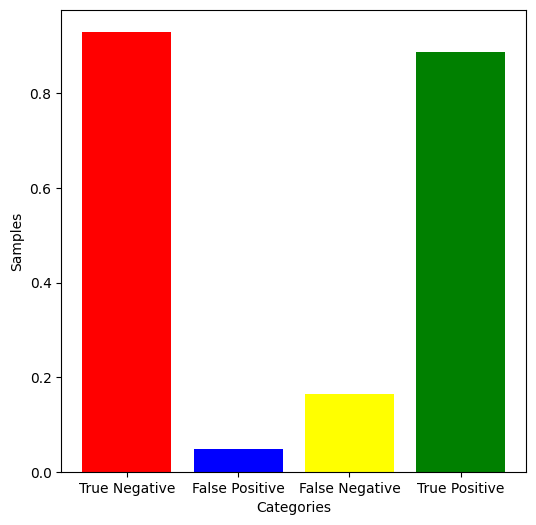

In [31]:
# considering very-mild, mild and moderate to be positive and non-demented to be negative
Y_pred = random_forest.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred)

total_negative = np.sum(conf_matrix[0])
total_positive = Y_test.shape[0] - total_negative
tn = conf_matrix[0][0] / total_negative
fn = (conf_matrix[1][0] + conf_matrix[2][0] + conf_matrix[3][0]) / total_negative
fp = (conf_matrix[0][1] + conf_matrix[0][2] + conf_matrix[0][3]) / total_positive
tp = 0

for i in range(1,4):
    for j in range(1,4):
        tp += conf_matrix[i][j]
tp = tp / total_positive

plt.figure(figsize=(6,6))
categories = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
counts = [tn, fp, fn, tp]

plt.bar(categories ,counts, color = ['Red', 'Blue', 'Yellow', 'Green'])
plt.xlabel('Categories')
plt.ylabel('Samples')
plt.show()



In [69]:

def build_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal',
                     input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation="relu", kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation="relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    model.summary()

    return model

model = build_model()

def checkpoint_callback():
    checkpoint_filepath = './checkpoint'
    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback

class_weight = compute_class_weight('balanced',classes=np.unique(Y_train), y=Y_train)
class_weights = dict(zip(np.unique(Y_train), class_weight))

max_weight = max(class_weights.values())
class_weights = {cls: weight / max_weight for cls, weight in class_weights.items()}


print(class_weights)

model = build_model()

EPOCHS = 20
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]



height = 128
width = 128
channels = 1

print(X_train_og.shape)

X_train_reshaped = X_train.reshape(-1, height, width, channels)
X_val_reshaped = X_val.reshape(-1, height, width, channels)

# Train the model
history = model.fit(X_train_reshaped, Y_train, epochs=EPOCHS, validation_data=(X_val_reshaped, Y_val))



history = model.fit(X_train, epochs=EPOCHS, validation_data=X_val, class_weight=class_weights, callbacks=callbacks)


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_90 (MaxPooli  (None, 63, 63, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_91 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_91 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_92 (Conv2D)          (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_92 (MaxPooli  (None, 14, 14, 128)     

ValueError: cannot reshape array of size 1564000 into shape (128,128,1)